<a href="https://colab.research.google.com/github/9000HAL/AutonomousDriving_Capstone_CALTECH_simplilearn.ipynb/blob/main/AutonomousDriving_Capstone.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
project_dir = "/content/drive/MyDrive/AutonomousDriving_Capstone"

In [4]:
%cp -r "$project_dir/Images.zip" /content/

In [5]:
!mkdir -p /content/AutonomousDriving/Images
!unzip -q /content/Images.zip -d /content/AutonomousDriving/Images

In [9]:
import os

extracted = os.listdir("/content/AutonomousDriving/Images")
print("Extracted contents:", extracted)

# If a single subfolder exists (e.g., 'Images'), update image_dir:
if len(extracted) == 1 and os.path.isdir(os.path.join("/content/AutonomousDriving/Images", extracted[0])):
    image_dir = os.path.join("/content/AutonomousDriving/Images", extracted[0])
else:
    image_dir = "/content/AutonomousDriving/Images"

print("Using image directory:", image_dir)
print("Sample image files:", sorted(os.listdir(image_dir))[:10])

Extracted contents: ['Images']
Using image directory: /content/AutonomousDriving/Images/Images
Sample image files: ['00000000.jpg', '00000001.jpg', '00000002.jpg', '00000003.jpg', '00000004.jpg', '00000005.jpg', '00000006.jpg', '00000007.jpg', '00000008.jpg', '00000009.jpg']


In [10]:
import pandas as pd

labels_path = f"{project_dir}/labels.csv"  # remember gabe to adjust if needed
df = pd.read_csv(labels_path, header=None, names=['image_id', 'class', 'xmin', 'ymin', 'xmax', 'ymax'])
print("CSV head:")
print(df.head(10))

CSV head:
   image_id              class  xmin  ymin  xmax  ymax
0         0       pickup_truck   213    34   255    50
1         0                car   194    78   273   122
2         0                car   155    27   183    35
3         0  articulated_truck    43    25   109    55
4         0                car   106    32   124    45
5         1                bus   205   155   568   314
6         1                bus   285   123   477   168
7         1                car   544   162   617   193
8         1                car   329   152   371   163
9         1                car   447   161   497   183


In [11]:
available_files = sorted(os.listdir(image_dir))
available_ids = set([int(fname.split('.')[0]) for fname in available_files if fname.endswith('.jpg')])
print("Total available image IDs:", len(available_ids))
print("Example available image IDs:", list(available_ids)[:5])

Total available image IDs: 5626
Example available image IDs: [0, 1, 2, 3, 4]


In [12]:
df['image_id'] = df['image_id'].astype(int)
df_filtered = df[df['image_id'].isin(available_ids)]
print("Annotations before filtering:", len(df))
print("Annotations after filtering:", len(df_filtered))

Annotations before filtering: 351549
Annotations after filtering: 17967


In [13]:
unique_ids = sorted(df_filtered['image_id'].unique())
print("Unique image IDs in filtered CSV:", len(unique_ids))

Unique image IDs in filtered CSV: 5626


In [14]:
import math, random
random.seed(42)
random.shuffle(unique_ids)
split_index = math.floor(0.8 * len(unique_ids))
train_ids = unique_ids[:split_index]
val_ids = unique_ids[split_index:]
print(f"Training images: {len(train_ids)}, Validation images: {len(val_ids)}")

Training images: 4500, Validation images: 1126


In [15]:
classes = ['car', 'bus', 'pickup_truck', 'articulated_truck', 'motorized_vehicle',
           'work_van', 'single_unit_truck', 'pedestrian', 'bicycle', 'motorcycle', 'non-motorized_vehicle']
class_to_id = {cls_name: idx for idx, cls_name in enumerate(classes)}
print("Class mapping:", class_to_id)

Class mapping: {'car': 0, 'bus': 1, 'pickup_truck': 2, 'articulated_truck': 3, 'motorized_vehicle': 4, 'work_van': 5, 'single_unit_truck': 6, 'pedestrian': 7, 'bicycle': 8, 'motorcycle': 9, 'non-motorized_vehicle': 10}


In [16]:
!mkdir -p /content/AutonomousDriving/yolo/images/train
!mkdir -p /content/AutonomousDriving/yolo/images/val
!mkdir -p /content/AutonomousDriving/yolo/labels/train
!mkdir -p /content/AutonomousDriving/yolo/labels/val

In [17]:
def get_filename_from_id(img_id):
    return f"{img_id:08d}.jpg"

# Test the mapping
for test in [0, 1, 3802]:
    print(f"Image ID {test} -> {get_filename_from_id(test)}")

Image ID 0 -> 00000000.jpg
Image ID 1 -> 00000001.jpg
Image ID 3802 -> 00003802.jpg


In [29]:
import shutil
from PIL import Image

# Rename the column in the DataFrame after loading the CSV
df_filtered.rename(columns={'class': 'class_label'}, inplace=True)

def process_dataset(id_list, split):
    for img_id in id_list:
        filename = get_filename_from_id(img_id)
        src_path = os.path.join(image_dir, filename)
        if not os.path.exists(src_path):
            print(f"File not found: {filename}")
            continue
        # Copy image to the corresponding folder
        dst_img_path = f"/content/AutonomousDriving/yolo/images/{split}/{filename}"
        shutil.copy(src_path, dst_img_path)

        # Get all annotations for this image
        rows = df_filtered[df_filtered['image_id'] == img_id]
        label_lines = []

        # Open image to get width and height
        with Image.open(src_path) as img:
            w, h = img.size
        for row in rows.itertuples(index=False):
            cls_name = row.class_label  # now using 'class_label' instead of 'class' or 'class_'
            xmin, ymin, xmax, ymax = row.xmin, row.ymin, row.xmax, row.ymax
            if cls_name not in class_to_id:
                continue
            cls_id = class_to_id[cls_name]
            x_center = ((xmin + xmax) / 2) / w
            y_center = ((ymin + ymax) / 2) / h
            box_width = (xmax - xmin) / w
            box_height = (ymax - ymin) / h
            label_lines.append(f"{cls_id} {x_center:.6f} {y_center:.6f} {box_width:.6f} {box_height:.6f}")

        # Write label file (even if no annotations, then create an empty file)
        label_file = f"/content/AutonomousDriving/yolo/labels/{split}/{os.path.splitext(filename)[0]}.txt"
        with open(label_file, 'w') as f:
            f.write("\n".join(label_lines))

# Process training and validation splits
process_dataset(train_ids, "train")
process_dataset(val_ids, "val")

print("Training images count:", len(os.listdir("/content/AutonomousDriving/yolo/images/train")))
print("Validation images count:", len(os.listdir("/content/AutonomousDriving/yolo/images/val")))

<ipython-input-29-1e2e37f47c79>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered.rename(columns={'class': 'class_label'}, inplace=True)


Training images count: 4500
Validation images count: 1126


In [30]:
%cd /content
!git clone https://github.com/ultralytics/yolov5.git
%cd yolov5
!pip install -r requirements.txt

/content
Cloning into 'yolov5'...
remote: Enumerating objects: 17270, done.
remote: Counting objects: 100% (1/1), done.
remote: Total 17270 (delta 0), reused 0 (delta 0), pack-reused 17269 (from 2)
Receiving objects: 100% (17270/17270), 16.11 MiB | 29.93 MiB/s, done.
Resolving deltas: 100% (11861/11861), done.
/content/yolov5
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 67.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 36.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 47.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [31]:
%%bash
cat > data.yaml << 'EOL'
train: /content/AutonomousDriving/yolo/images/train
val: /content/AutonomousDriving/yolo/images/val

nc: 11
names: ['car', 'bus', 'pickup_truck', 'articulated_truck', 'motorized_vehicle', 'work_van', 'single_unit_truck', 'pedestrian', 'bicycle', 'motorcycle', 'non-motorized_vehicle']
EOL

In [32]:
!cat data.yaml

train: /content/AutonomousDriving/yolo/images/train
val: /content/AutonomousDriving/yolo/images/val

nc: 11
names: ['car', 'bus', 'pickup_truck', 'articulated_truck', 'motorized_vehicle', 'work_van', 'single_unit_truck', 'pedestrian', 'bicycle', 'motorcycle', 'non-motorized_vehicle']


In [33]:
!python train.py --data data.yaml --cfg yolov5s.yaml --weights yolov5s.pt --img 640 --batch 16 --epochs 20 --name vehicle-detector

Streaming output truncated to the last 5000 lines.
  with torch.cuda.amp.autocast(amp):
      11/19      3.82G    0.02916    0.02027    0.01573         84        640:  25% 71/282 [00:25<01:22,  2.56it/s]/content/yolov5/train.py:412: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(amp):
      11/19      3.82G    0.02916     0.0202    0.01586         71        640:  26% 72/282 [00:25<01:13,  2.88it/s]/content/yolov5/train.py:412: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(amp):
      11/19      3.82G    0.02923     0.0203    0.01595        124        640:  26% 73/282 [00:26<01:35,  2.20it/s]/content/yolov5/train.py:412: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(amp

In [34]:
!python detect.py --weights runs/train/vehicle-detector/weights/best.pt --source /content/AutonomousDriving/yolo/images/val --conf 0.25 --name infer_val

detect: weights=['runs/train/vehicle-detector/weights/best.pt'], source=/content/AutonomousDriving/yolo/images/val, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_format=0, save_csv=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=infer_val, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-398-g5cdad892 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)

Fusing layers... 
YOLOv5s summary: 157 layers, 7039792 parameters, 0 gradients, 15.8 GFLOPs
image 1/1126 /content/AutonomousDriving/yolo/images/val/00000003.jpg: 448x640 2 cars, 1 pickup_truck, 1 motorized_vehicle, 29.4ms
image 2/1126 /content/AutonomousDriving/yolo/images/val/00000004.jpg: 448x640 1 bus, 9.0ms
image 3/1126 /content/AutonomousDriving/yolo/imag

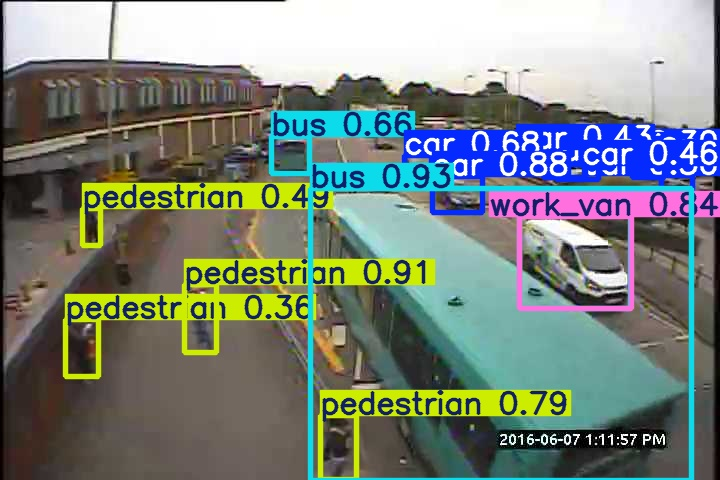

In [35]:
from IPython.display import Image, display
# Replace with a known filename from validation set
sample_output = "runs/detect/infer_val/00001565.jpg"
display(Image(filename=sample_output))

In [36]:
!cp runs/train/vehicle-detector/weights/best.pt "$project_dir/best_vehicle_detector.pt"